(5000, 3) Index(['Unnamed: 0', 'en', 'fr'], dtype='object')
Number of input tokens 210
Number of output tokens 172
(5000, 8)
(5000, 10)
Model: "Seq2Seq-Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder-Input-Layer (Input  [(None, None, 210)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 Decoder-Input-Layer (Input  [(None, None, 172)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 Encoder-LSTM-Layer (LSTM)   [(None, 60),        

None
Epoch 1/10
63/63 [==============================] - 6s 36ms/step - loss: 2.3804 - accuracy: 0.7801 - val_loss: 1.2981 - val_accuracy: 0.7838
Epoch 2/10
 5/63 [=>............................] - ETA: 1s - loss: 1.0983 - accuracy: 0.8206

C:\Users\jayanti.prasad\Anaconda3\envs\aiml_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 1s 20ms/step - loss: 1.0775 - accuracy: 0.8204 - val_loss: 1.2566 - val_accuracy: 0.7838
Epoch 3/10
63/63 [==============================] - 1s 17ms/step - loss: 1.0575 - accuracy: 0.8204 - val_loss: 1.2427 - val_accuracy: 0.7838
Epoch 4/10
63/63 [==============================] - 1s 19ms/step - loss: 1.0470 - accuracy: 0.8204 - val_loss: 1.2356 - val_accuracy: 0.7838
Epoch 5/10
63/63 [==============================] - 1s 20ms/step - loss: 1.0374 - accuracy: 0.8204 - val_loss: 1.2263 - val_accuracy: 0.7838
Epoch 6/10
63/63 [==============================] - 1s 17ms/step - loss: 1.0255 - accuracy: 0.8204 - val_loss: 1.2125 - val_accuracy: 0.7838
Epoch 7/10
63/63 [==============================] - 1s 19ms/step - loss: 1.0079 - accuracy: 0.8204 - val_loss: 1.1835 - val_accuracy: 0.7838
Epoch 8/10
63/63 [==============================] - 1s 18ms/step - loss: 0.9724 - accuracy: 0.8206 - val_loss: 1.1556 - val_accuracy: 0.7839
Epoch 9/10
63/63 [======

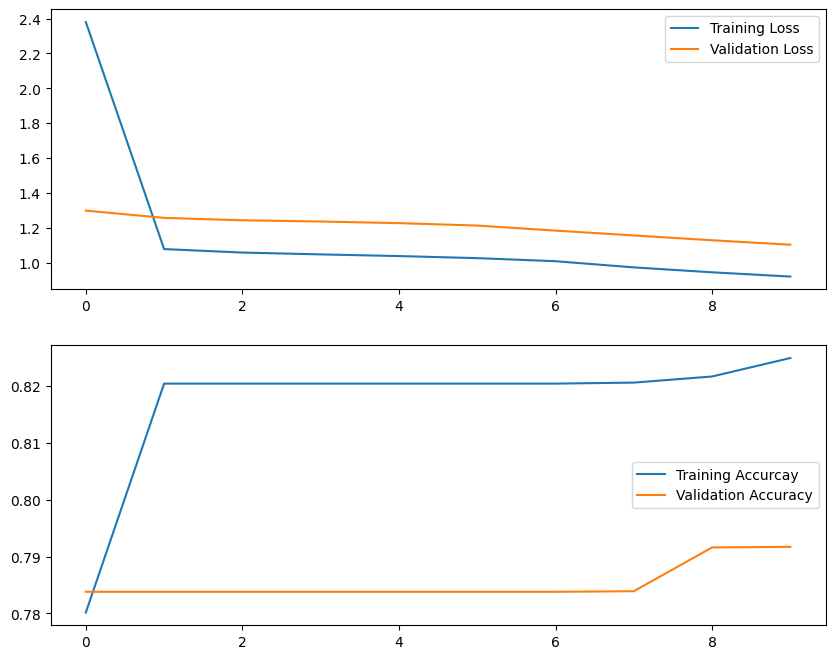

In [6]:
import sys
import os
import numpy as np
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,  TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences

np.random.seed (seed=203)

workspace_dir = "tmp"
vocab_threshold  = 10
input_seq_len = 8
output_seq_len = 10 
latent_dim = 60 

def get_data ():
    data_path = r"C:\Users\jayanti.prasad\Data\NLP_DATA\seq2seq_data\english-french-sentence-pairs.csv"
    df = pd.read_csv(data_path, encoding='utf-8',nrows=5000)
    print(df.shape, df.columns)
    return df  


def build_vocabulary(input_data, output_data):
     V = []
     for data in [input_data, output_data]:
        tokens = " ".join (data).split(" ")
        vocab = Counter (tokens)
        token_dict = dict (vocab)
        df = pd.DataFrame (columns=['word','count'])
        df ['word'] = list (token_dict.keys())
        df ['count'] = list (token_dict.values())
        df = df.sort_values (by=['count'], ascending=False, ignore_index=True)
        V.append (df)
     return V                          
    


def text2vec (input_text, df_vocab, vocab_size, vec_len):
    D = df_vocab.iloc[:vocab_size]
    ids = [i for i in range (0, len (D))]
    D = D.assign (id=ids)
    D.index = D['word'].to_list()
    text_vecs = []
    for text in input_text:
        words = text.split(" ")
        words = [w for w in words if w in D.index]
        vec = [D.loc[w]['id'] for w in words]
        # do padding 
        if len (vec) > vec_len:
            vec = vec[:vec_len]
        if len (vec) < vec_len:
            vec = vec + [0] * (vec_len - len(vec))
        text_vecs.append (vec)
    return np.array (text_vecs)     


class Seq2Seq_Model:
    def __init__(self, workspace_dir, num_encoder_tokens,num_decoder_tokens,latent_dim):
        
        self.workspace = workspace_dir 
        self.model_dir = self.workspace + os.sep + "trained_model"
        self.log_dir = self.workspace + os.sep + "log"

        os.makedirs(self.workspace, exist_ok=True)
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)

        # Define and process the input sequence
        encoder_inputs = Input(shape=(None, num_encoder_tokens),name='Encoder-Input-Layer')
        encoder = LSTM(latent_dim, return_state=True,name='Encoder-LSTM-Layer')
        encoder_outputs, state_h, state_c = encoder(encoder_inputs)

        # We discard `encoder_outputs` and only keep the states.
        encoder_states = [state_h, state_c]

        # Using `encoder_states` set up the decoder as initial state.
        decoder_inputs = Input(shape=(None, num_decoder_tokens),name='Decoder-Input-Layer')
        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,name='Decoder-LSTM-Layer')
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(num_decoder_tokens, activation='softmax',name='Decoder-Dense-Layer')
        decoder_outputs = decoder_dense(decoder_outputs)
        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs,name='Seq2Seq-Model')

    def fit_model(self, encoder_in_data, decoder_in_data, decoder_target_data, nepochs):
        batch_size = 64             
        chkpt = ModelCheckpoint(filepath=self.model_dir + os.sep + "model.hdf5",
             save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

        tboard = TensorBoard(log_dir=self.log_dir)
        callbacks = [chkpt, tboard]

        # Compiling and training the model
        self.model.compile(optimizer=Adam(lr=0.01),metrics=['accuracy'],
                     loss='categorical_crossentropy')
        hist = self.model.fit([encoder_in_data, decoder_in_data],
            decoder_target_data, callbacks=callbacks, batch_size=batch_size, epochs=nepochs,
            validation_split=0.2)
        return hist


if __name__ == "__main__":
    # get the data 
    df = get_data()

    # create workspace directory 
    os.makedirs (workspace_dir, exist_ok=True)

    input_texts = df['en'].to_list()
    output_texts = df['fr'].to_list() 
    
    [df_ivocab, df_ovocab ] =  build_vocabulary(input_texts, output_texts)

    df_ivocab.to_csv(workspace_dir + os.sep + "vocab_inp.csv")
    df_ovocab.to_csv(workspace_dir + os.sep + "vocab_out.csv") 

    df_ivocab = df_ivocab [df_ivocab['count'] > vocab_threshold]
    df_ovocab = df_ovocab [df_ovocab['count'] > vocab_threshold]

    num_input_tokens = len (df_ivocab)
    num_output_tokens = len (df_ovocab)

    print("Number of input tokens", num_input_tokens)
    print("Number of output tokens", num_output_tokens)
    
    input_vecs = text2vec (input_texts, df_ivocab, num_input_tokens, input_seq_len)
    output_vecs   = text2vec (output_texts, df_ovocab, num_output_tokens, output_seq_len)

    print(input_vecs.shape)
    print(output_vecs.shape)

    M = Seq2Seq_Model (workspace_dir, num_input_tokens,num_output_tokens,latent_dim)
    print(M.model.summary())

    encoder_in_data = np.zeros((len(input_vecs), input_seq_len, num_input_tokens), dtype='float32')
    decoder_in_data = np.zeros((len(input_vecs), output_seq_len, num_output_tokens), dtype='float32')
    decoder_target_data = np.zeros((len(input_vecs), output_seq_len, num_output_tokens), dtype='float32')

    for i in range (0, len (input_vecs)):
       if  (len (input_vecs[i]) > 0)  & (len (output_vecs[i]) > 0): 
           for j, token_id in enumerate (input_vecs[i]):
               encoder_in_data[i, j, token_id] = 1
           for j, tokein_id in enumerate (output_vecs[i][1:]):
               decoder_in_data[i, j, token_id] = 1
           for j, token_id in enumerate (output_vecs[i][:-1]):
               decoder_target_data[i, j, token_id] = 1

    hist = M.fit_model(encoder_in_data, decoder_in_data, decoder_target_data, 10)

    fig, axs  = plt.subplots (2,1,figsize=(10,8))
    axs[0].plot(hist.history['loss'],label='Training Loss')
    axs[0].plot(hist.history['val_loss'],label='Validation Loss')
    axs[1].plot(hist.history['accuracy'],label='Training Accurcay')
    axs[1].plot(hist.history['val_accuracy'],label='Validation Accuracy')
    axs[0].legend()
    axs[1].legend()
    plt.show()


